In [1]:
import math
import numpy as np
from tensorGrad import Tensor, softmax, cross_entropy
from tensorGrad.optimize import Adam, AdamW, SGD_M, Nesterov
xp = np     # later: allow override xp = cupy
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import fetch_openml
import numpy as np

In this notebook we use the lightweight TensorGrad library to train a small multi-layer perceptron (MLP) on the classic MNIST dataset.

The workflow covers:

- downloading / pre-processing MNIST images and labels,
- building a neural network with ReLU activations,
- optimising with Adam and autograd,
- tracking training / test accuracy, and
- visualising losses, sample predictions, and mis-classified digits.

In [2]:
# Download MNIST (this returns numpy arrays directly)
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist.data, mnist.target.astype(int)

# Split train/test
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

# Normalize to 0-1
X_train = X_train.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0

#wrap as tensorGrad tensors
X_batch = Tensor(X_train[:64])
y_batch = Tensor(y_train[:64], requires_grad=False)


In [4]:
print(X_train.min(), X_train.max())  

0.0 1.0


In [3]:
from tensorGrad.nn import Linear, ReLU, Sequential

model = Sequential(
       Linear(784, 128),  # input → hidden-1
       ReLU(),
       Linear(128, 64),   # hidden-1 → hidden-2
       ReLU(),
       Linear(64, 10)     # hidden-2 → logits
   )
# or model = MLP(784, [128, 64], 10)

for i, p in enumerate(model.parameters(), 1):
    print(f"param {i:>2}: shape {p.shape}, requires_grad={p.requires_grad}")

total = sum(p.data.size for p in model.parameters())
print("total scalars:", total)

param  1: shape (784, 128), requires_grad=True
param  2: shape (128,), requires_grad=True
param  3: shape (128, 64), requires_grad=True
param  4: shape (64,), requires_grad=True
param  5: shape (64, 10), requires_grad=True
param  6: shape (10,), requires_grad=True
total scalars: 109386


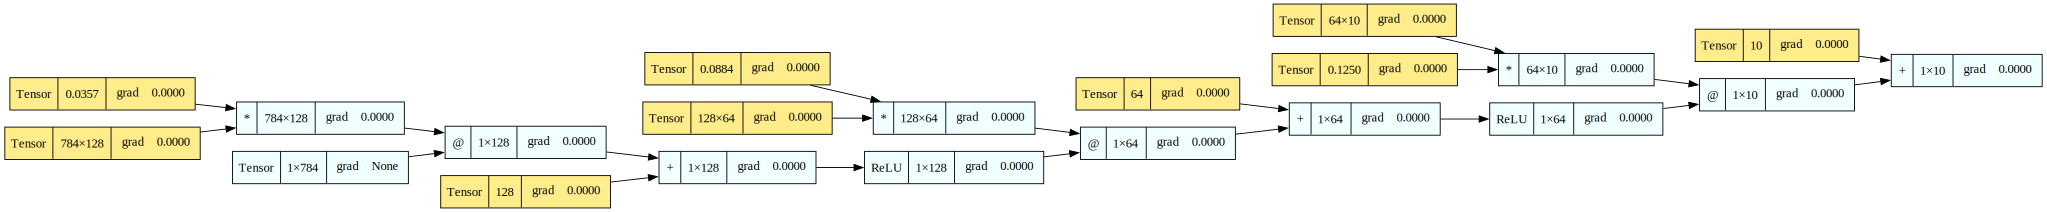

In [4]:
# ╔════════════════════════════════════════════════════════════════╗
# ║  High-level Graphviz view of the MLP with grad statistics      ║
# ╚════════════════════════════════════════════════════════════════╝
from graphviz import Digraph
from tensorGrad.engine import Tensor
import math

def _shape_or_value(t: Tensor) -> str:
    #Return scalar value or shape string for display.
    return (
        f"{t.data:.4f}"
        if t.data.size == 1
        else "×".join(map(str, t.shape))
    )

def _grad_norm(t: Tensor) -> str:
    #L2-norm (sqrt of sum of squares) of the gradient tensor.
    if t.grad is None:
        return "None"
    return f"{math.sqrt((t.grad**2).sum()):.4f}"

def draw_mlp_dot(root: Tensor) -> Digraph:
    #Render a compact autograd graph with label, shape/value, and grad-norm.
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})
    seen = set()

    def build(v: Tensor):
        uid = str(id(v))
        if uid in seen:
            return
        seen.add(uid)

        # --- node styling ----------------------------------------------------
        is_param_leaf = v.requires_grad and not v._prev
        fill = "lightgoldenrod1" if is_param_leaf else "azure"
        lbl = (
            f"{{ {v.label or v._op or 'Tensor'} | "
            f"{_shape_or_value(v)} | "
            f"∥grad∥ {_grad_norm(v)} }}"
        )
        dot.node(uid, label=lbl, shape="record", style="filled", fillcolor=fill)

        # --- edges -----------------------------------------------------------
        for child in v._prev:
            dot.edge(str(id(child)), uid)
            build(child)

    build(root)
    return dot

# -- capture a sample graph ---------------------------------------
with Tensor.no_grad():
    sample_X = Tensor(X_train[:1])
logits = model(sample_X)

draw_mlp_dot(logits)      # Jupyter will display the SVG inline

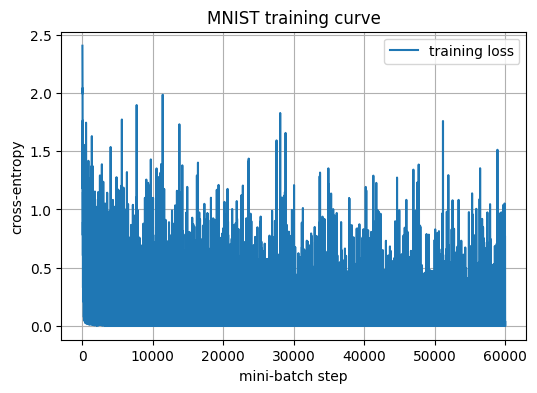

In [5]:
#initialize the hyperparameters
batch_size = 10
learning_rate = 1e-3
n_epochs = 10
optimizer = Adam(model.parameters(), learning_rate=learning_rate)

batch_losses = []

#training loop
for epoch in range(n_epochs):
    perm = np.random.permutation(len(X_train))
    for i in range(0, len(X_train), batch_size):
        idx = perm[i : i + batch_size]
        X_batch = Tensor(X_train[idx])
        y_batch = Tensor(y_train[idx], requires_grad=False)
        logits = model(X_batch)
        loss = cross_entropy(logits, y_batch)
        batch_losses.append(loss.data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

#training loss curve
plt.figure(figsize=(6,4))
plt.plot(batch_losses, label="training loss")
plt.xlabel("mini-batch step")
plt.ylabel("cross-entropy")
plt.title("MNIST training curve")
plt.legend()
plt.grid(True)
plt.show()

In [6]:
print("final batch loss:", batch_losses[-1])

steps_per_epoch = len(X_train) // batch_size
final_epoch_losses = batch_losses[-steps_per_epoch:]
final_avg = sum(final_epoch_losses) / steps_per_epoch
print("final average loss:", final_avg)

final batch loss: 0.0017509758
final average loss: 0.023869499577637565


### Interpreting the derived loss  
The very last mini-batch had a loss of **0.0018**, and the average loss over the entire last epoch was **0.0239**.  
Loss numbers that small mean the model is almost always assigning very high probability to the correct digit on the training data—effectively ~99 % training accuracy.  

**Remember:**
 training loss alone isn’t enough—we now need to run the model on the unseen test set to check how well it really generalises and predicts against unseen data it hasnt been explicity trained on.

we should expect a test loss only modestly above the training loss and the accuracy should be at least > 90%.

If **test loss is much higher while training loss is tiny**, it signals over-fitting (too much capacity or not enough regularisation).

If **both training and test losses stay high**, the model is under-trained (more epochs, higher learning-rate, or different architecture), or the dataset is too small/imbalanced to learn the task well.

In [9]:
# -- Evaluation on the 10 000-image test set -------------------------
with Tensor.no_grad():                       # no grad tracking
    X_test_t = Tensor(X_test)                # wrap once
    y_test_t = Tensor(y_test, requires_grad=False)

logits_test = model(X_test_t)                # forward pass
test_loss = cross_entropy(logits_test, y_test_t)

preds = logits_test.data.argmax(axis=1)      # predicted labels
test_acc = (preds == y_test).mean() * 100    # percentage

print(f"test loss  : {float(test_loss.data):.4f}")
print(f"test accuracy: {test_acc:.2f}%")

test loss  : 0.1271
test accuracy: 97.34%


The test loss is only a little higher than the training loss, and the accuracy is comfortably above 90 % .  
That tells us the model didn’t just memorise the training images—it learned features that generalise well to new digits. 

For a simple three-layer MLP trained for ten epochs, this is about as good as we can expect on MNIST without additional tricks.